# Homework05

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
   

In [28]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
# Load in data and create train and test datasets

with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [3]:
### Set up the components of the Decoder block: 
# MultiHeadAttention
# FeedForward Network

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [4]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

In [5]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [6]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

In [15]:
import matplotlib.pyplot as plt

# Define the model, optimizer, etc.

# Initialize model
model = LanguageModel()
print(device)
model.to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
for i in range(max_iters):
    optimizer.zero_grad()
    X, Y = get_batch('train')
    logits, loss = model(X, Y)
    loss.backward()
    optimizer.step()

    if i % eval_interval == 0:
        train_loss, val_loss = estimate_loss().values()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {i}: Training Loss: {train_loss}, validation Loss: {val_loss}")



cuda
Epoch 0: Training Loss: 4.1131815910339355, validation Loss: 4.116000175476074
Epoch 10: Training Loss: 3.3815951347351074, validation Loss: 3.423449754714966
Epoch 20: Training Loss: 3.2260074615478516, validation Loss: 3.2708933353424072
Epoch 30: Training Loss: 3.073533058166504, validation Loss: 3.1120123863220215
Epoch 40: Training Loss: 2.94637393951416, validation Loss: 2.975520133972168
Epoch 50: Training Loss: 2.8589305877685547, validation Loss: 2.868769884109497
Epoch 60: Training Loss: 2.7901062965393066, validation Loss: 2.7921438217163086
Epoch 70: Training Loss: 2.7254865169525146, validation Loss: 2.736145257949829
Epoch 80: Training Loss: 2.6773552894592285, validation Loss: 2.684232234954834
Epoch 90: Training Loss: 2.65739107131958, validation Loss: 2.6649575233459473
Epoch 100: Training Loss: 2.6257760524749756, validation Loss: 2.639742136001587
Epoch 110: Training Loss: 2.6101796627044678, validation Loss: 2.6055097579956055
Epoch 120: Training Loss: 2.593597

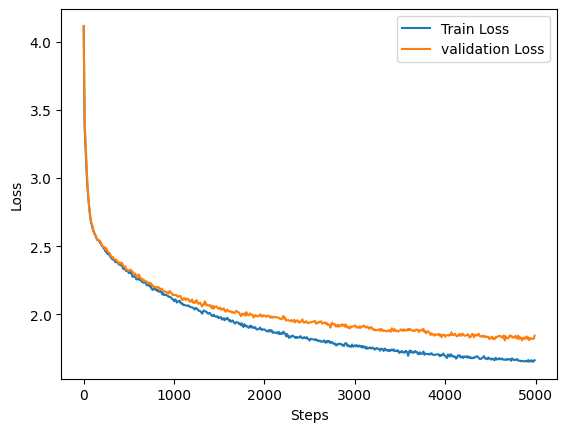

In [16]:
# Plot the training and validation losses
plt.plot(range(0, max_iters, eval_interval), train_losses, label='Train Loss')
plt.plot(range(0, max_iters, eval_interval), val_losses, label='validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# test this model
initial_text = "I am a person"
initial_indices = torch.tensor([encode(initial_text)], dtype=torch.long).to(device)

# Number of new tokens to generate
max_new_tokens = 30

# Generate text
with torch.no_grad():
    generated_indices = model.generate(initial_indices, max_new_tokens)

# Convert generated indices back to text
generated_text = decode(generated_indices[0].tolist())

print(generated_text)

I am a person; sight and be kin yours,
and 


### homework 2
2. Run the same training loop but modify one of the hyperparameters from this list: 

#### hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

In [15]:
## parameters I used

hyperparams = [
    {'n_embd': 64, 'n_head': 4, 'n_layer': 4},
    {'n_embd': 128, 'n_head': 4, 'n_layer': 4},
    {'n_embd': 64, 'n_head': 8, 'n_layer': 4},
    {'n_embd': 64, 'n_head': 4, 'n_layer': 8}
]

eval_interval = 100

In [16]:
# store perplexities for each run
train_losses = [[] for _ in range(4)]
val_losses = [[] for _ in range(4)]

# inital 4 models
model_list = []
for i in range(4):
    # print(i)
    model_list.append(LanguageModel())
    model_list[i].to(device)


modelindex = 0   
# Loop over each set of hyperparameters
for hp in hyperparams:
    print("********************************************************************************")
    print(f"Training with hyperparameters: n_embd={hp['n_embd']},n_head={hp['n_head']}, n_layer={hp['n_layer']}, model index={modelindex}")
    print("********************************************************************************")
    # Unpack hyperparameters
    n_embd = hp['n_embd']
    n_head = hp['n_head']
    n_layer = hp['n_layer']
    
    # Function to estimate loss
    @torch.no_grad()
    def estimate_loss():
        out = {}
        model_list[modelindex].eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                logits, loss = model_list[modelindex](X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model_list[modelindex].train()
        return out

    # Initialize optimizer
    optimizer = torch.optim.Adam(model_list[modelindex].parameters(), lr=learning_rate)

    # Training loop
    for i in range(max_iters):
        optimizer.zero_grad()
        X, Y = get_batch('train')
        logits, loss = model_list[modelindex](X, Y)
        loss.backward()
        optimizer.step()

        if i % eval_interval == 0:
            train_loss, val_loss = estimate_loss().values()
            train_losses[modelindex].append(train_loss)
            val_losses[modelindex].append(val_loss)
            print(f"Epoch {i}: Train Loss: {train_loss}, Val Loss: {val_loss}")
    modelindex += 1
    print("********************************************************************************")


********************************************************************************
Training with hyperparameters: n_embd=64,n_head=4, n_layer=4, model index=0
********************************************************************************
Epoch 0: Train Loss: 4.0947465896606445, Val Loss: 4.103906154632568
Epoch 100: Train Loss: 2.6542913913726807, Val Loss: 2.6602556705474854
Epoch 200: Train Loss: 2.488370895385742, Val Loss: 2.5000417232513428
Epoch 300: Train Loss: 2.4061853885650635, Val Loss: 2.424967050552368
Epoch 400: Train Loss: 2.345740556716919, Val Loss: 2.358886957168579
Epoch 500: Train Loss: 2.299259901046753, Val Loss: 2.3151144981384277
Epoch 600: Train Loss: 2.241511344909668, Val Loss: 2.261539936065674
Epoch 700: Train Loss: 2.192791223526001, Val Loss: 2.205050230026245
Epoch 800: Train Loss: 2.1508092880249023, Val Loss: 2.187325954437256
Epoch 900: Train Loss: 2.120487928390503, Val Loss: 2.137847423553467
Epoch 1000: Train Loss: 2.075073719024658, Val Loss: 2.11

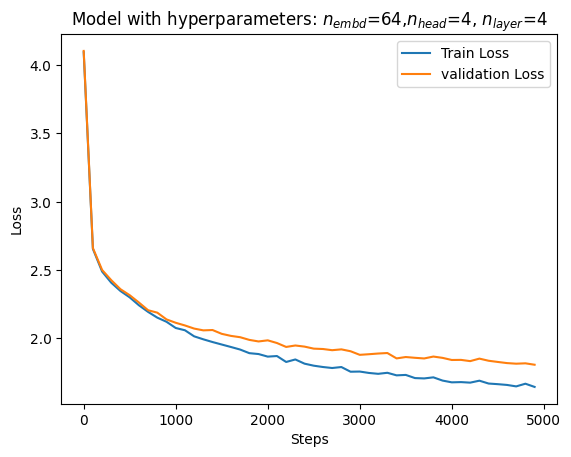

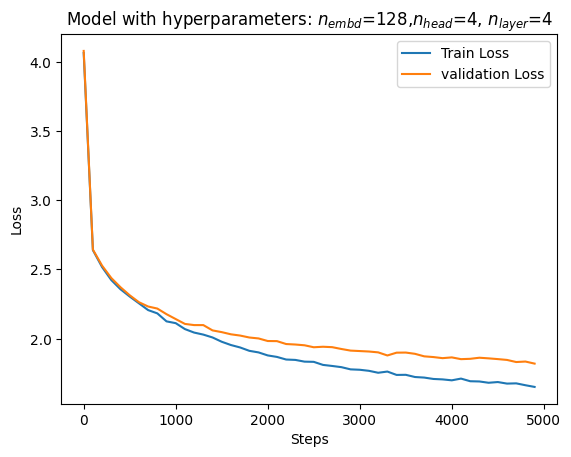

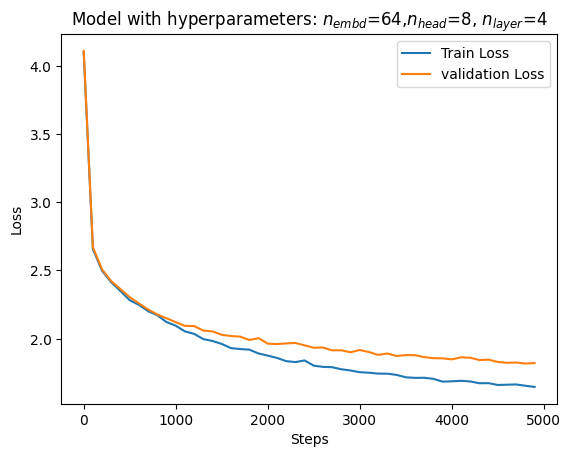

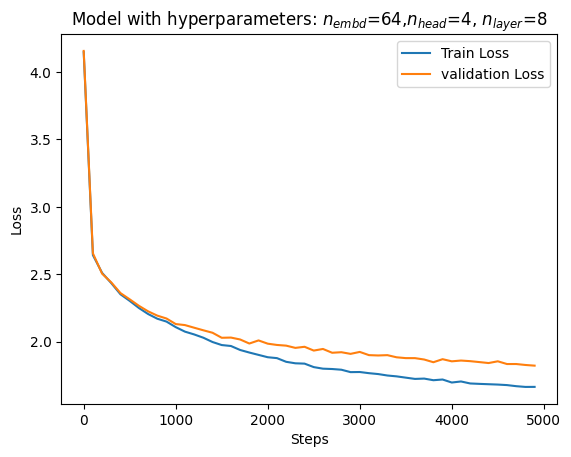

In [25]:
import matplotlib.pyplot as plt
modelindex = 0   
# Loop over each set of hyperparameters
for hp in hyperparams:
    n_embd = hp['n_embd']
    n_head = hp['n_head']
    n_layer = hp['n_layer']
    # Plot the training and validation losses
    plt.plot(range(0, max_iters, eval_interval), train_losses[modelindex], label='Train Loss')
    plt.plot(range(0, max_iters, eval_interval), val_losses[modelindex], label='validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title("Model with hyperparameters: $n_{embd}$="f"{n_embd}"",$n_{head}$="f"{n_head}"", $n_{layer}$="f"{n_layer}")
    plt.legend()
    plt.show()
    modelindex += 1
    plt.close()


# # Bonus 1:
output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others?

In [27]:
# test this model
initial_text = "I am a person"
initial_indices = torch.tensor([encode(initial_text)], dtype=torch.long).to(device)

# Number of new tokens to generate
max_new_tokens = 30

# Generate text
with torch.no_grad():
    generated_indices0 = model_list[0].generate(initial_indices, max_new_tokens)
    generated_indices1 = model_list[1].generate(initial_indices, max_new_tokens)
    generated_indices2 = model_list[2].generate(initial_indices, max_new_tokens)
    generated_indices3 = model_list[3].generate(initial_indices, max_new_tokens)

# Convert generated indices back to text
generated_text0 = decode(generated_indices0[0].tolist())
generated_text1 = decode(generated_indices1[0].tolist())
generated_text2 = decode(generated_indices2[0].tolist())
generated_text3 = decode(generated_indices3[0].tolist())

print('Model 1\n')
print(generated_text0)

print('\n\nModel 2\n')
print(generated_text1)

print('\n\nModel 3\n')
print(generated_text2)

print('\n\nModel 4\n')
print(generated_text3)

Model 1

I am a personing of to deak them.
The call 


Model 2

I am a person?
Thee in mamey spain at you o


Model 3

I am a person
And enious woose of werel god


Model 4

I am a person printate,
On Like and noth's 


## Those results are subtle. The model4 seems more reasonable.